In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [55]:
df = pd.read_parquet("outputs/esri_with_polluted_heatday_coldday_hotspot.parquet")

In [56]:
df = df.drop(columns=["tmax","tmin","pm25"])

In [57]:
df.head()

wfday  heatday  coldday  polluted  hotspot
time       FIPS                                              
2005-12-31 1765.0  False    False    False     False    False
           1766.0  False    False    False     False    False
           1767.0  False    False    False     False    False
           1768.0  False    False    False     False    False
           1769.0  False    False    False     False    False

## Get time lag

In [58]:
eve1 = "wfday"
eve2 = "polluted"

In [59]:
hdf = df[df[eve1] | df[eve2]]

In [60]:
hdf = hdf[[eve1, eve2]].reset_index()

In [62]:
hdf["cco1"] = np.where(
    hdf[eve1] & hdf[eve2], # find cocurence point
    False, # cut period with the cocurence point
    hdf[eve1]
)

In [63]:
hdf["cco2"] = np.where(
    hdf[eve1] & hdf[eve2], # find cocurence point
    False, # cut period with the cocurence point
    hdf[eve2]
)

In [65]:
hdf = hdf.sort_values(['time'])
grouped_hdf = hdf.groupby(["FIPS"])

In [66]:
# remove sequences in event 1

hdf['shift_plus'] = grouped_hdf['cco1'].shift(fill_value = False)
hdf['shift_minus'] = grouped_hdf['cco1'].shift(-1, fill_value = False)
# gets first and last day in a sequence of days
hdf['mask'] = ~hdf[['cco1','shift_plus','shift_minus']].min(axis=1)

In [68]:
# remove sequences in event 2

hdf['shift_plus'] = grouped_hdf['cco2'].shift(fill_value = False)
hdf['shift_minus'] = grouped_hdf['cco2'].shift(-1, fill_value = False)
# gets first and last day in a sequence of days
hdf['mask2'] = ~hdf[['cco2','shift_plus','shift_minus']].min(axis=1)

In [70]:
hdf = hdf[hdf["mask"]]

In [72]:
hdf = hdf[hdf["mask2"]]

In [74]:
hdf = hdf.drop(columns=['cco1','cco2','shift_plus','shift_minus','mask','mask2'])

In [ ]:
# time lag == 0

res = hdf[hdf[eve1] & hdf[hdf[eve2]]]
res['difference'] = 0

In [ ]:
res.head()

In [76]:
# difference between consequentive events per location

hdf['difference'] = hdf.groupby('FIPS')['time'].diff()

In [77]:
hdf[hdf["FIPS"]==4056.0].head(30)

,time,FIPS,wfday,polluted,difference
2152,2006-02-03,4056.0,False,True,NaT
5241,2006-02-09,4056.0,True,False,6 days
6512,2006-02-10,4056.0,False,True,1 days
8127,2006-02-16,4056.0,True,False,6 days
8418,2006-02-24,4056.0,False,True,8 days
9580,2006-03-15,4056.0,True,False,19 days
15614,2006-11-30,4056.0,True,False,260 days
17461,2006-12-05,4056.0,False,True,5 days
20073,2006-12-13,4056.0,True,False,8 days
38607,2007-02-01,4056.0,True,False,50 days


In [182]:
df = df.reset_index()
df['time'] = pd.to_datetime(df['time'])

In [191]:
df_weekly = df.groupby("FIPS").resample('2M', on="time").sum()

In [192]:
df_weekly.head()

index      FIPS  wfday  heatday  coldday  polluted  \
FIPS   time                                                                 
1765.0 2005-12-31          0    1765.0      0        0        0         0   
       2006-02-28   15914070  104135.0      0        0       14         0   
       2006-04-30   49360590  107665.0      0        0       12         0   
       2006-06-30   82816101  107665.0      0        8        0         0   
       2006-08-31  118456425  109430.0      0       19        0         0   

                   hotspot  
FIPS   time                 
1765.0 2005-12-31        0  
       2006-02-28        0  
       2006-04-30        0  
       2006-06-30        0  
       2006-08-31        0

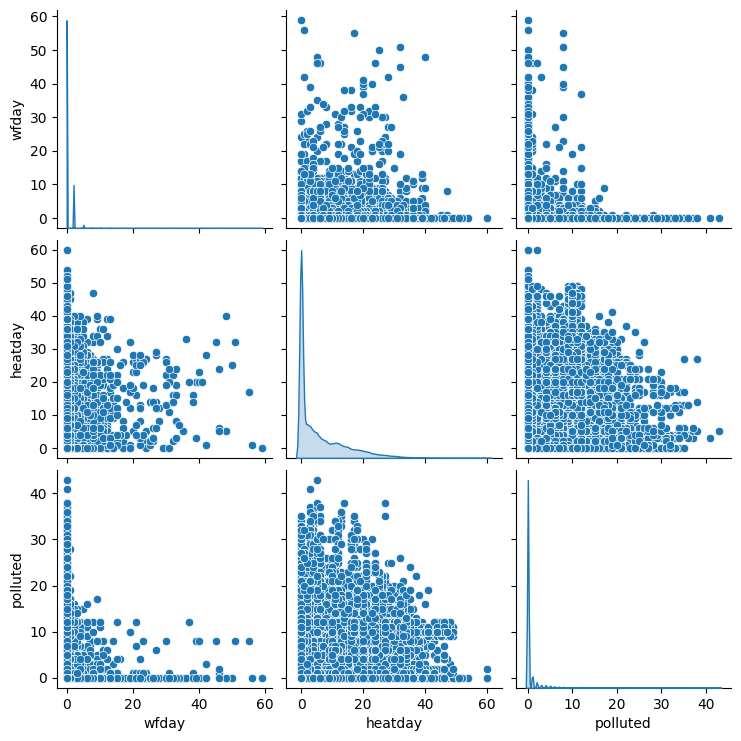

In [198]:
sns.pairplot(
    df_weekly[["wfday","heatday","polluted"]], diag_kind="kde")
plt.show()

In [149]:
# get FIPS with wfires

temp = df[df['wfday']].reset_index()["FIPS"]
temp = temp.value_counts().head(5)
fips_list = temp.index

In [150]:
temp = df.reset_index()["FIPS"].isin(fips_list)

In [151]:
temp_df = df.reset_index()
temp_df = temp_df[temp]

In [45]:
temp_df.head()

,time,FIPS,wfday,heatday,coldday,polluted,hotspot
2276,2005-12-31,4056.0,False,False,False,False,False
6468,2005-12-31,8281.0,False,False,False,False,False
6734,2005-12-31,8550.0,False,False,False,False,False
6866,2005-12-31,8688.0,False,False,False,False,False
7135,2005-12-31,8961.0,False,False,False,False,False


In [46]:
temp_df.FIPS.value_counts()

4056.0    5844
8281.0    5844
8550.0    5844
8688.0    5844
8961.0    5844
Name: FIPS, dtype: int64

In [47]:
temp_df = temp_df[temp_df.FIPS == 4056.0]

In [48]:
temp_df = temp_df.set_index("time").drop(columns=["FIPS","coldday","hotspot"])

<AxesSubplot: ylabel='time'>

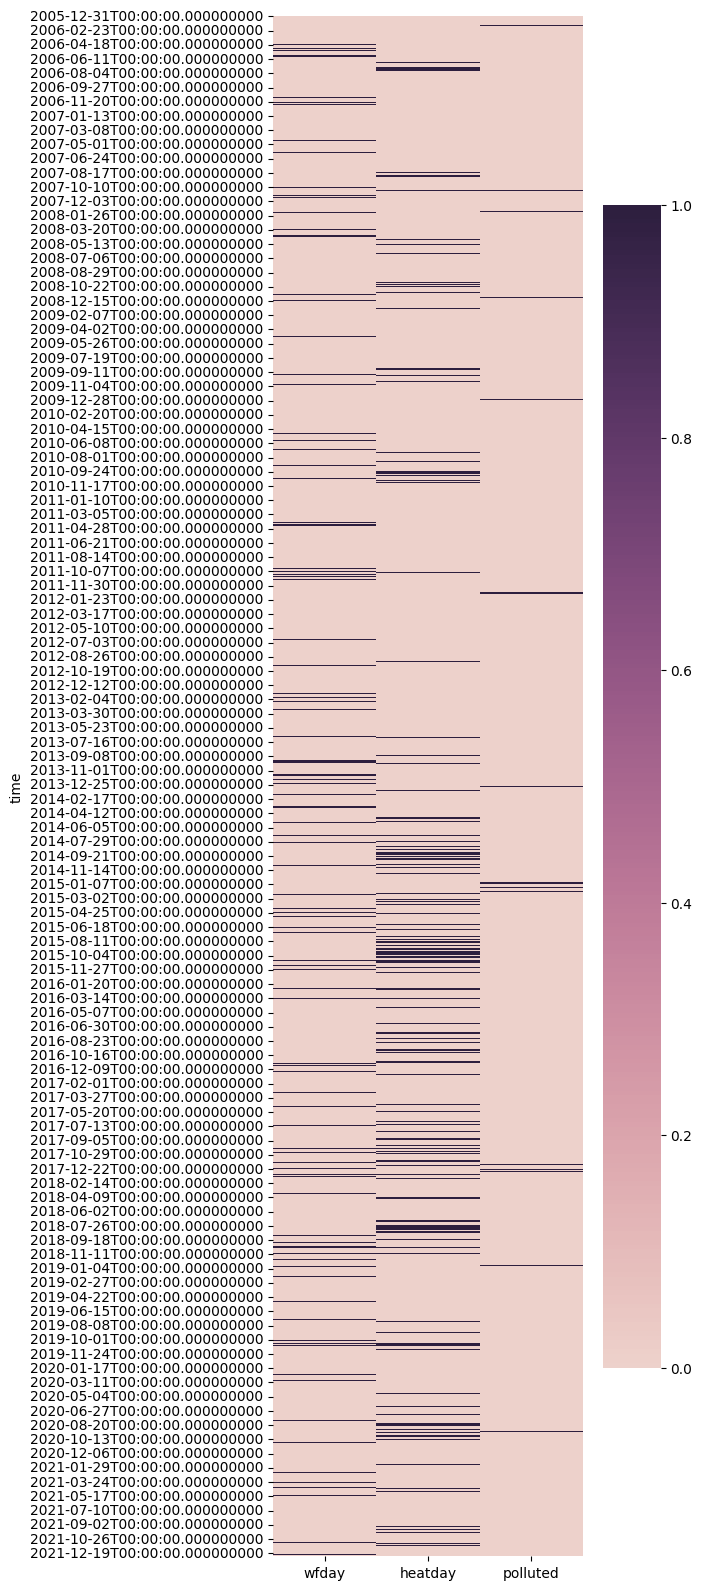

In [57]:
fig, axes = plt.subplots(1, 1, figsize=(5, 20), sharey=True)
sns.heatmap(temp_df, cmap=sns.cubehelix_palette(as_cmap=True))

In [58]:
temp_df = temp_df[temp_df['wfday'] | (temp_df['heatday'] | temp_df['polluted'])]

In [58]:
temp_df = temp_df[temp_df['wfday'] | (temp_df['heatday'] | temp_df['polluted'])]

<AxesSubplot: ylabel='time'>

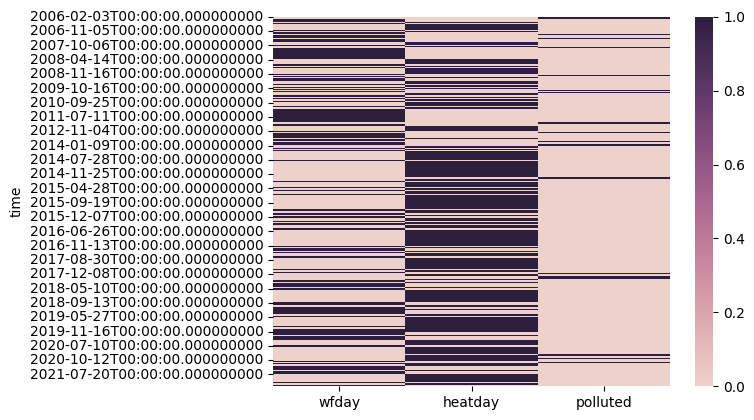

In [59]:
sns.heatmap(temp_df, cmap=sns.cubehelix_palette(as_cmap=True))

In [60]:
temp_df.head()

,wfday,heatday,polluted
time,,,
2006-02-03,False,False,True
2006-02-09,True,False,False
2006-02-10,False,False,True
2006-02-16,True,False,False
2006-02-24,False,False,True


In [71]:
temp_df = temp_df.reset_index()

In [86]:
temp_df['day_difference'] = temp_df['time'].diff()

In [87]:
temp_df.head()

,time,wfday,heatday,polluted,day_difference
0,2006-02-03,False,False,True,NaT
1,2006-02-09,True,False,False,6 days
2,2006-02-10,False,False,True,1 days
3,2006-02-16,True,False,False,6 days
4,2006-02-24,False,False,True,8 days


In [139]:
wh_df.head(20)

,time,wfday,heatday,day_difference,wfday_shift,mask,wfday_shift_1,wfday_shift_-1
3,2006-02-16,True,False,7 days,NaN,True,NaN,True
14,2006-06-15,True,False,14 days,True,True,True,False
15,2006-06-24,False,True,9 days,True,True,True,False
17,2006-06-26,False,True,1 days,False,True,False,True
18,2006-06-29,True,False,3 days,False,True,False,False
19,2006-07-12,False,True,13 days,True,True,True,False
34,2006-07-27,False,True,1 days,False,True,False,True
36,2006-10-17,True,False,10 days,False,True,False,False
38,2006-11-05,False,True,1 days,True,True,True,False
39,2006-11-06,False,True,1 days,False,True,False,True


In [145]:
mask = np.where(wh_df['heatday'] == False, False, (
    (wh_df['heatday'] == wh_df['wfday'].shift()) 
))

In [146]:
wh_df[mask].day_difference.describe()

count                           96
mean               4 days 11:45:00
std      4 days 00:49:02.082334249
min                1 days 00:00:00
25%                1 days 00:00:00
50%                3 days 00:00:00
75%                7 days 00:00:00
max               14 days 00:00:00
Name: day_difference, dtype: object

In [104]:
wh_df[["time","wfday","wfday_shift","day_difference"]].head(20)

,time,wfday,wfday_shift,day_difference
3,2006-02-16,True,NaN,7 days
6,2006-03-27,True,True,12 days
8,2006-04-19,True,True,2 days
9,2006-04-21,True,True,2 days
10,2006-05-02,True,True,11 days
11,2006-05-09,True,True,7 days
13,2006-06-01,True,True,4 days
14,2006-06-15,True,True,14 days
15,2006-06-24,False,True,9 days
16,2006-06-25,False,False,1 days


In [8]:
df = df[df['wfday'] | (df['heatday'] | df['polluted'])]

In [6]:
df['previous_heatday'] = df.groupby('FIPS')['heatday'].transform(lambda x: x.shift(1))

In [8]:
df['previous_polluted'] = df.groupby('FIPS')['polluted'].transform(lambda x: x.shift(1))

In [9]:
df['time'] = pd.to_datetime(df['time'])

In [10]:
df['day_difference'] = df.groupby('FIPS')['time'].diff()

In [12]:
df[df['FIPS'] == '02496'].head()

,time,FIPS,tmax,tmin,pm25,polluted,tmax90,heatday,hotspot,previous_heatday,previous_polluted,day_difference
36683,2006-01-04,02496,17.850000,6.050012,36.700001,True,37.749992,False,False,NaN,NaN,NaT
45674,2006-01-05,02496,18.149988,5.850000,38.260000,True,37.749992,False,False,False,True,1 days
72647,2006-01-08,02496,13.649988,2.350000,47.230001,True,37.749992,False,False,False,True,3 days
81638,2006-01-09,02496,14.450006,2.350000,50.369999,True,37.749992,False,False,False,True,1 days
90629,2006-01-10,02496,15.350000,4.050012,39.290001,True,37.749992,False,False,False,True,1 days


In [17]:
df['day_difference']

36683          NaT
39905          NaT
42121          NaT
42122          NaT
42123          NaT
             ...  
52273118    9 days
52273120   17 days
52273181    1 days
52273182    1 days
52282173    1 days
Name: day_difference, Length: 5637828, dtype: timedelta64[ns]

In [ ]:
df.plot.hist(column='day_difference')

In [ ]:

# create a rolling window of size 7 and apply the any() method to check if any value in the window is True
df['event2_before_event1'] = (df['event2'].rolling(7, min_periods=1).apply(any) & df['event1']).values

In [ ]:

# shift event2 column by 1 to check if event2 happened the day before event1
df['event2_before_event1'] = df['event2'].shift(1) & df['event1']

# use the where method to get the date of the first occurrence of event2 before event1
df['first_occurrence_of_event2_before_event1'] = df['date'].where(df['event2_before_event1'], np.nan)

In [2]:
import xarray as xr

In [3]:
pm25 = xr.open_dataset('data/esri/PM25_Nature_2006_2020_Cali.nc')

In [9]:
df = pm25["MEAN_NONE_SPATIAL_NEIGHBORS"].to_dataframe()

In [11]:
df = df.reset_index()

In [14]:
df = df[df['locations'] == 3]

In [15]:
import matplotlib as plt

<AxesSubplot: xlabel='time'>

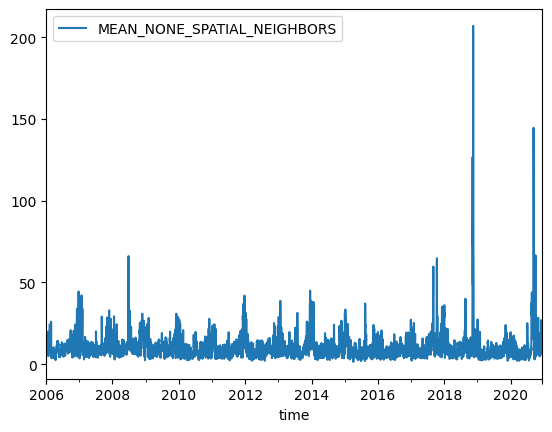

In [17]:
df.plot.line(x='time', y='MEAN_NONE_SPATIAL_NEIGHBORS')

<AxesSubplot: ylabel='Frequency'>

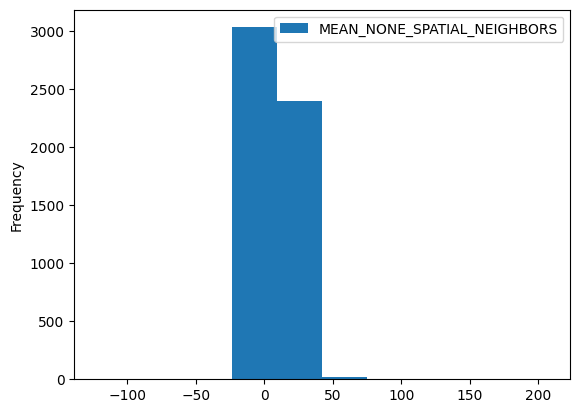

In [20]:
df.plot.hist(column='MEAN_NONE_SPATIAL_NEIGHBORS')

In [12]:
df.head()

,time,locations,lat,lon,MEAN_NONE_SPATIAL_NEIGHBORS
0,2005-12-31,0,37.867656,-122.231882,4.986000
1,2005-12-31,1,37.848138,-122.249591,5.500000
2,2005-12-31,2,37.840584,-122.254478,5.486667
3,2005-12-31,3,37.848284,-122.257445,5.437778
4,2005-12-31,4,37.848545,-122.264736,5.480000


In [24]:
df = pd.DataFrame({
'date': ["2008-01-01","2008-01-01","2008-01-02","2008-01-02","2008-01-03","2008-01-03","2008-01-04","2008-01-04"],
'fips': [1003,1007,1003,1007,1003,1007,1003,1007],
'wildfire':[1, 0, 1, 0, 0, 1, 0, 1],
'air_pollution':[0, 0, 1, 1, 0, 1, 0, 1],
})

In [25]:
# Convert the time column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [26]:
df

,date,fips,wildfire,air_pollution
0,2008-01-01,1003,1,0
1,2008-01-01,1007,0,0
2,2008-01-02,1003,1,1
3,2008-01-02,1007,0,1
4,2008-01-03,1003,0,0
5,2008-01-03,1007,1,1
6,2008-01-04,1003,0,0
7,2008-01-04,1007,1,1


In [27]:
df_events = df[(df['wildfire'] == 1) | (df['air_pollution'] == 1)]

In [28]:
df_events

,date,fips,wildfire,air_pollution
0,2008-01-01,1003,1,0
2,2008-01-02,1003,1,1
3,2008-01-02,1007,0,1
5,2008-01-03,1007,1,1
7,2008-01-04,1007,1,1


In [32]:
# difference between consequentive events per location

df_events['difference'] = df_events.groupby('fips')['date'].diff()

/var/folders/b_/vlxgm9n10bz569rffzmcc5dc0000gn/T/ipykernel_18510/4109363887.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events['difference'] = df_events.groupby('fips')['date'].diff()


In [33]:
df_events

,date,fips,wildfire,air_pollution,difference,wildfire_cause
0,2008-01-01,1003,1,0,NaT,NaN
2,2008-01-02,1003,1,1,1 days,1.0
3,2008-01-02,1007,0,1,NaT,NaN
5,2008-01-03,1007,1,1,1 days,0.0
7,2008-01-04,1007,1,1,1 days,1.0


In [34]:
df_events['wildfire_cause'] = df_events.groupby('fips')['wildfire'].shift(1)

/var/folders/b_/vlxgm9n10bz569rffzmcc5dc0000gn/T/ipykernel_18510/930676913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events['wildfire_cause'] = df_events.groupby('fips')['wildfire'].shift(1)


## Time lag between wildfire and air pollution

In [35]:
df_events[(df_events['wildfire_cause'] == 1) & (df_events['air_pollution'] == 1)]['difference'].mean()

Timedelta('1 days 00:00:00')

In [36]:
df_events[(df_events['wildfire_cause'] == 1) & (df_events['air_pollution'] == 1)]['difference'].std()

Timedelta('0 days 00:00:00')

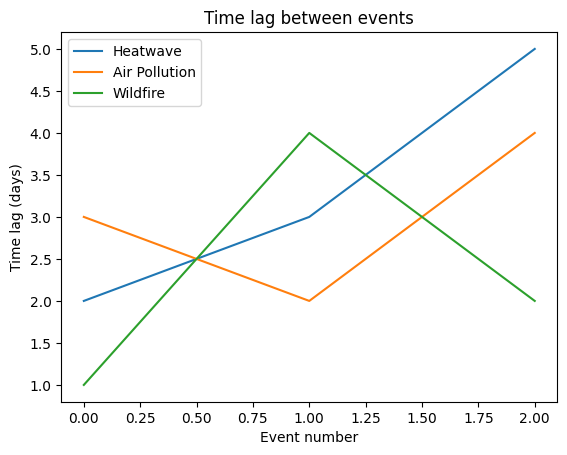

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Example data frame with calculated time lags
df = pd.DataFrame({
    'heatwave_time_diff': [2, 3, 5],
    'air_pollution_time_diff': [3, 2, 4],
    'wildfire_time_diff': [1, 4, 2]
})

# Plot the time lag between events
plt.plot(df['heatwave_time_diff'], label='Heatwave')
plt.plot(df['air_pollution_time_diff'], label='Air Pollution')
plt.plot(df['wildfire_time_diff'], label='Wildfire')

# Add labels and title
plt.xlabel('Event number')
plt.ylabel('Time lag (days)')
plt.title('Time lag between events')

# Show legend
plt.legend()

# Show plot
plt.show()

In [ ]:
# Example data frame with calculated time lags
df = pd.DataFrame({
    'heatwave_time_diff': [2, 3, 5],
    'air_pollution_time_diff': [3, 2, 4],
    'wildfire_time_diff': [1, 4, 2]
})

# Calculate average time lag and standard error of the mean
heatwave_mean = np.mean(df['heatwave_time_diff'])
heatwave_sem = np.std(df['heatwave_time_diff'])

air_pollution_mean = np.mean(df['air_pollution_time_diff'])
air_pollution_sem = np.std(df['air_pollution_time_diff'])

wildfire_mean = np.mean(df['wildfire_time_diff'])
wildfire_sem = np.std(df['wildfire_time_diff'])

# Print results
print(f'Heatwave average time lag: {heatwave_mean:.2f} ± {heatwave_sem:.2f} days')
print(f'Air pollution average time lag: {air_pollution_mean:.2f} ± {air_pollution_sem:.2f} days')
print(f'Wildfire average time lag: {wildfire_mean:.2f} ± {wildfire_sem:.2f} days')